<a href="https://colab.research.google.com/github/mpHarm88/DS-Unit-2-Regression-Classification/blob/master/module1/Mikio_Harman_assignment_regression_classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 1

## Assignment

You'll use another **New York City** real estate dataset. 

But now you'll **predict how much it costs to rent an apartment**, instead of how much it costs to buy a condo.

The data comes from renthop.com, an apartment listing website.

- [ ] Look at the data. Choose a feature, and plot its relationship with the target.
- [ ] Use scikit-learn for linear regression with one feature. You can follow the [5-step process from Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Basics-of-the-API).
- [ ] Define a function to make new predictions and explain the model coefficient.
- [ ] Organize and comment your code.

> [Do Not Copy-Paste.](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit) You must type each of these exercises in, manually. If you copy and paste, you might as well not even do them. The point of these exercises is to train your hands, your brain, and your mind in how to read, write, and see code. If you copy-paste, you are cheating yourself out of the effectiveness of the lessons.

## Stretch Goals
- [ ] Do linear regression with two or more features.
- [ ] Read [The Discovery of Statistical Regression](https://priceonomics.com/the-discovery-of-statistical-regression/)
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 2.1: What Is Statistical Learning?

In [ ]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module1')

In [392]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [393]:
# Read New York City apartment rental listing data
import pandas as pd
df = pd.read_csv('../data/apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)


In [394]:
# Remove outliers: 
# the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= 1375) & (df['price'] <= 15500) & 
        (df['latitude'] >=40.57) & (df['latitude'] < 40.99) &
        (df['longitude'] >= -74.1) & (df['longitude'] <= -73.38)]

df['created'] = pd.to_datetime(df["created"])
df["year"] = df["created"].dt.year
df['month'] = df["created"].dt.month
df["day"] = df["created"].dt.day
df["interest_level"] = df["interest_level"].map({"low":1,
                                                 "medium":2,
                                                "high":3})
df["extras"] = (df['elevator']+
                df["cats_allowed"]+
                df["hardwood_floors"]+
                df["dogs_allowed"]+
                df["doorman"]+
                df["dishwasher"]+
                df["no_fee"]+
                df["laundry_in_building"]+
                df["fitness_center"]+
                df["pre-war"]+
                df["laundry_in_unit"]+
                df["roof_deck"]+
                df["roof_deck"]+
                df["outdoor_space"]+
                df["dining_room"]+
                df["high_speed_internet"]+
                df["balcony"]+
                df["swimming_pool"]+
                df["new_construction"]+
                df["terrace"]+
                df["exclusive"]+
                df["loft"]+
                df["garden_patio"]+
                df["wheelchair_access"]+
                df["common_outdoor_space"]) 

def script(x):
    x = str(x)
    return 1 if len(x) > 50 else 0

df["has_script"] = df["description"].apply(script)

In [397]:
print(df['has_script'].value_counts(normalize=True))
df.describe(exclude="number")

1    0.919907
0    0.080093
Name: has_script, dtype: float64


,created,description,display_address,street_address
count,48818,47393,48685,48808
unique,48149,37854,8675,15136
top,2016-05-14 01:11:03,,Broadway,3333 Broadway
freq,3,1627,435,174
first,2016-04-01 22:12:41,NaN,NaN,NaN
last,2016-06-29 21:41:47,NaN,NaN,NaN


In [400]:
df["display_address"].value_counts()

Broadway                                                                                             435
East 34th Street                                                                                     355
Second Avenue                                                                                        349
Wall Street                                                                                          330
West 37th Street                                                                                     287
                                                                                                    ... 
63a Division St.                                                                                       1
1 west street                                                                                          1
PRIME LOCATION**BEST PRICE**ULTRA LUXURY**OVERSIZED 700 SQFT**WASHER&DRYER**TOP AMENITIES**SUBWAY      1
51st St                                                

In [413]:
my_str = "Broadway"
map_dict = {"Broadway":1,
            "East 34th Street":2,
            "Second Avenue":3,
            "West 37th Street":4}

df["address_encode"] = df["display_address"].map(map_dict)
df["address_encode"] = df["address_encode"].replace(np.NaN, 0)

In [414]:
df["address_encode"].value_counts()

0.0    47392
1.0      435
2.0      355
3.0      349
4.0      287
Name: address_encode, dtype: int64

[151636089521.01157, 61896063926.69135, 31053401614.910698, 17838360022.238697, 11751352097.45092, 8423175777.512374, 6127061127.910293, 4753736422.159492, 3717764251.1941414, 3069796462.618807, 2514077168.1362925, 2092506143.4574175, 1816373580.922976, 1544052824.708925, 1399224437.1674683, 1217445380.1564205, 1054799028.6767544, 957700452.9513967, 848569969.0153168]


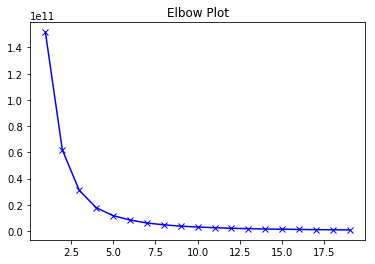

In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

df = df[list(df.describe().columns)]

# Elbow Plot for k (1-10)
K = range(1,20)

# The average distance from each centroid, to the points in its cluster
distortion = []
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df)
    distortion.append(kmeans.inertia_)

print(distortion)

# Elbow Plot

plt.plot(K, distortion, 'bx-')
plt.title("Elbow Plot")

plt.show()

In [444]:
n = 8
kmeans = KMeans(n_clusters = n)
kmeans.fit(df)
df["labels"] = kmeans.labels_

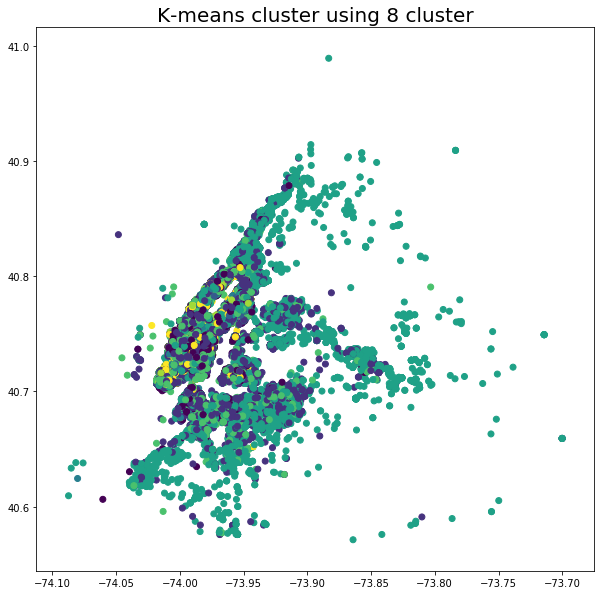

In [445]:
plt.figure(figsize=(10,10))
plt.scatter(df["longitude"], df["latitude"], c=df["labels"])
plt.title(f"K-means cluster using {n} cluster", fontsize=20)
plt.show()

In [446]:
df_mean = df[["price", "labels"]]
df_mean.groupby("labels").mean()

,price
labels,
0,4649.147508
1,2813.889507
2,13424.609929
3,7472.718208
4,2042.927756
5,3617.354856
6,9945.520661
7,5873.793326


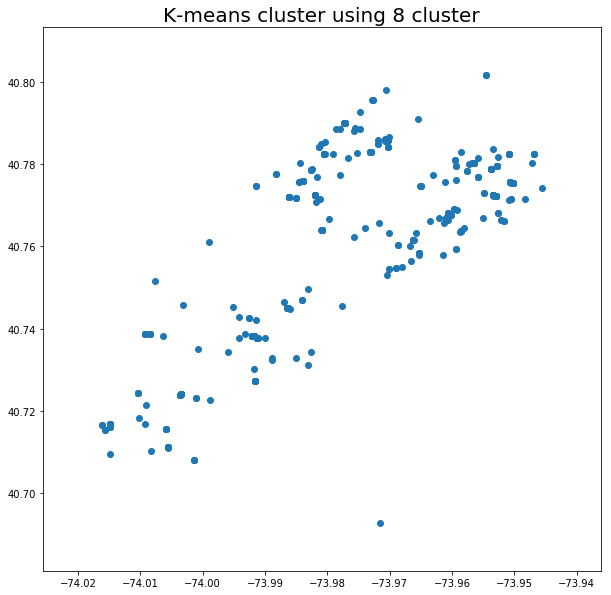

In [447]:
df_2 = df[df["labels"] == 2]

plt.figure(figsize=(10,10))
plt.scatter(df_2["longitude"], df_2["latitude"])
plt.title(f"K-means cluster using {n} cluster", fontsize=20)
plt.show()

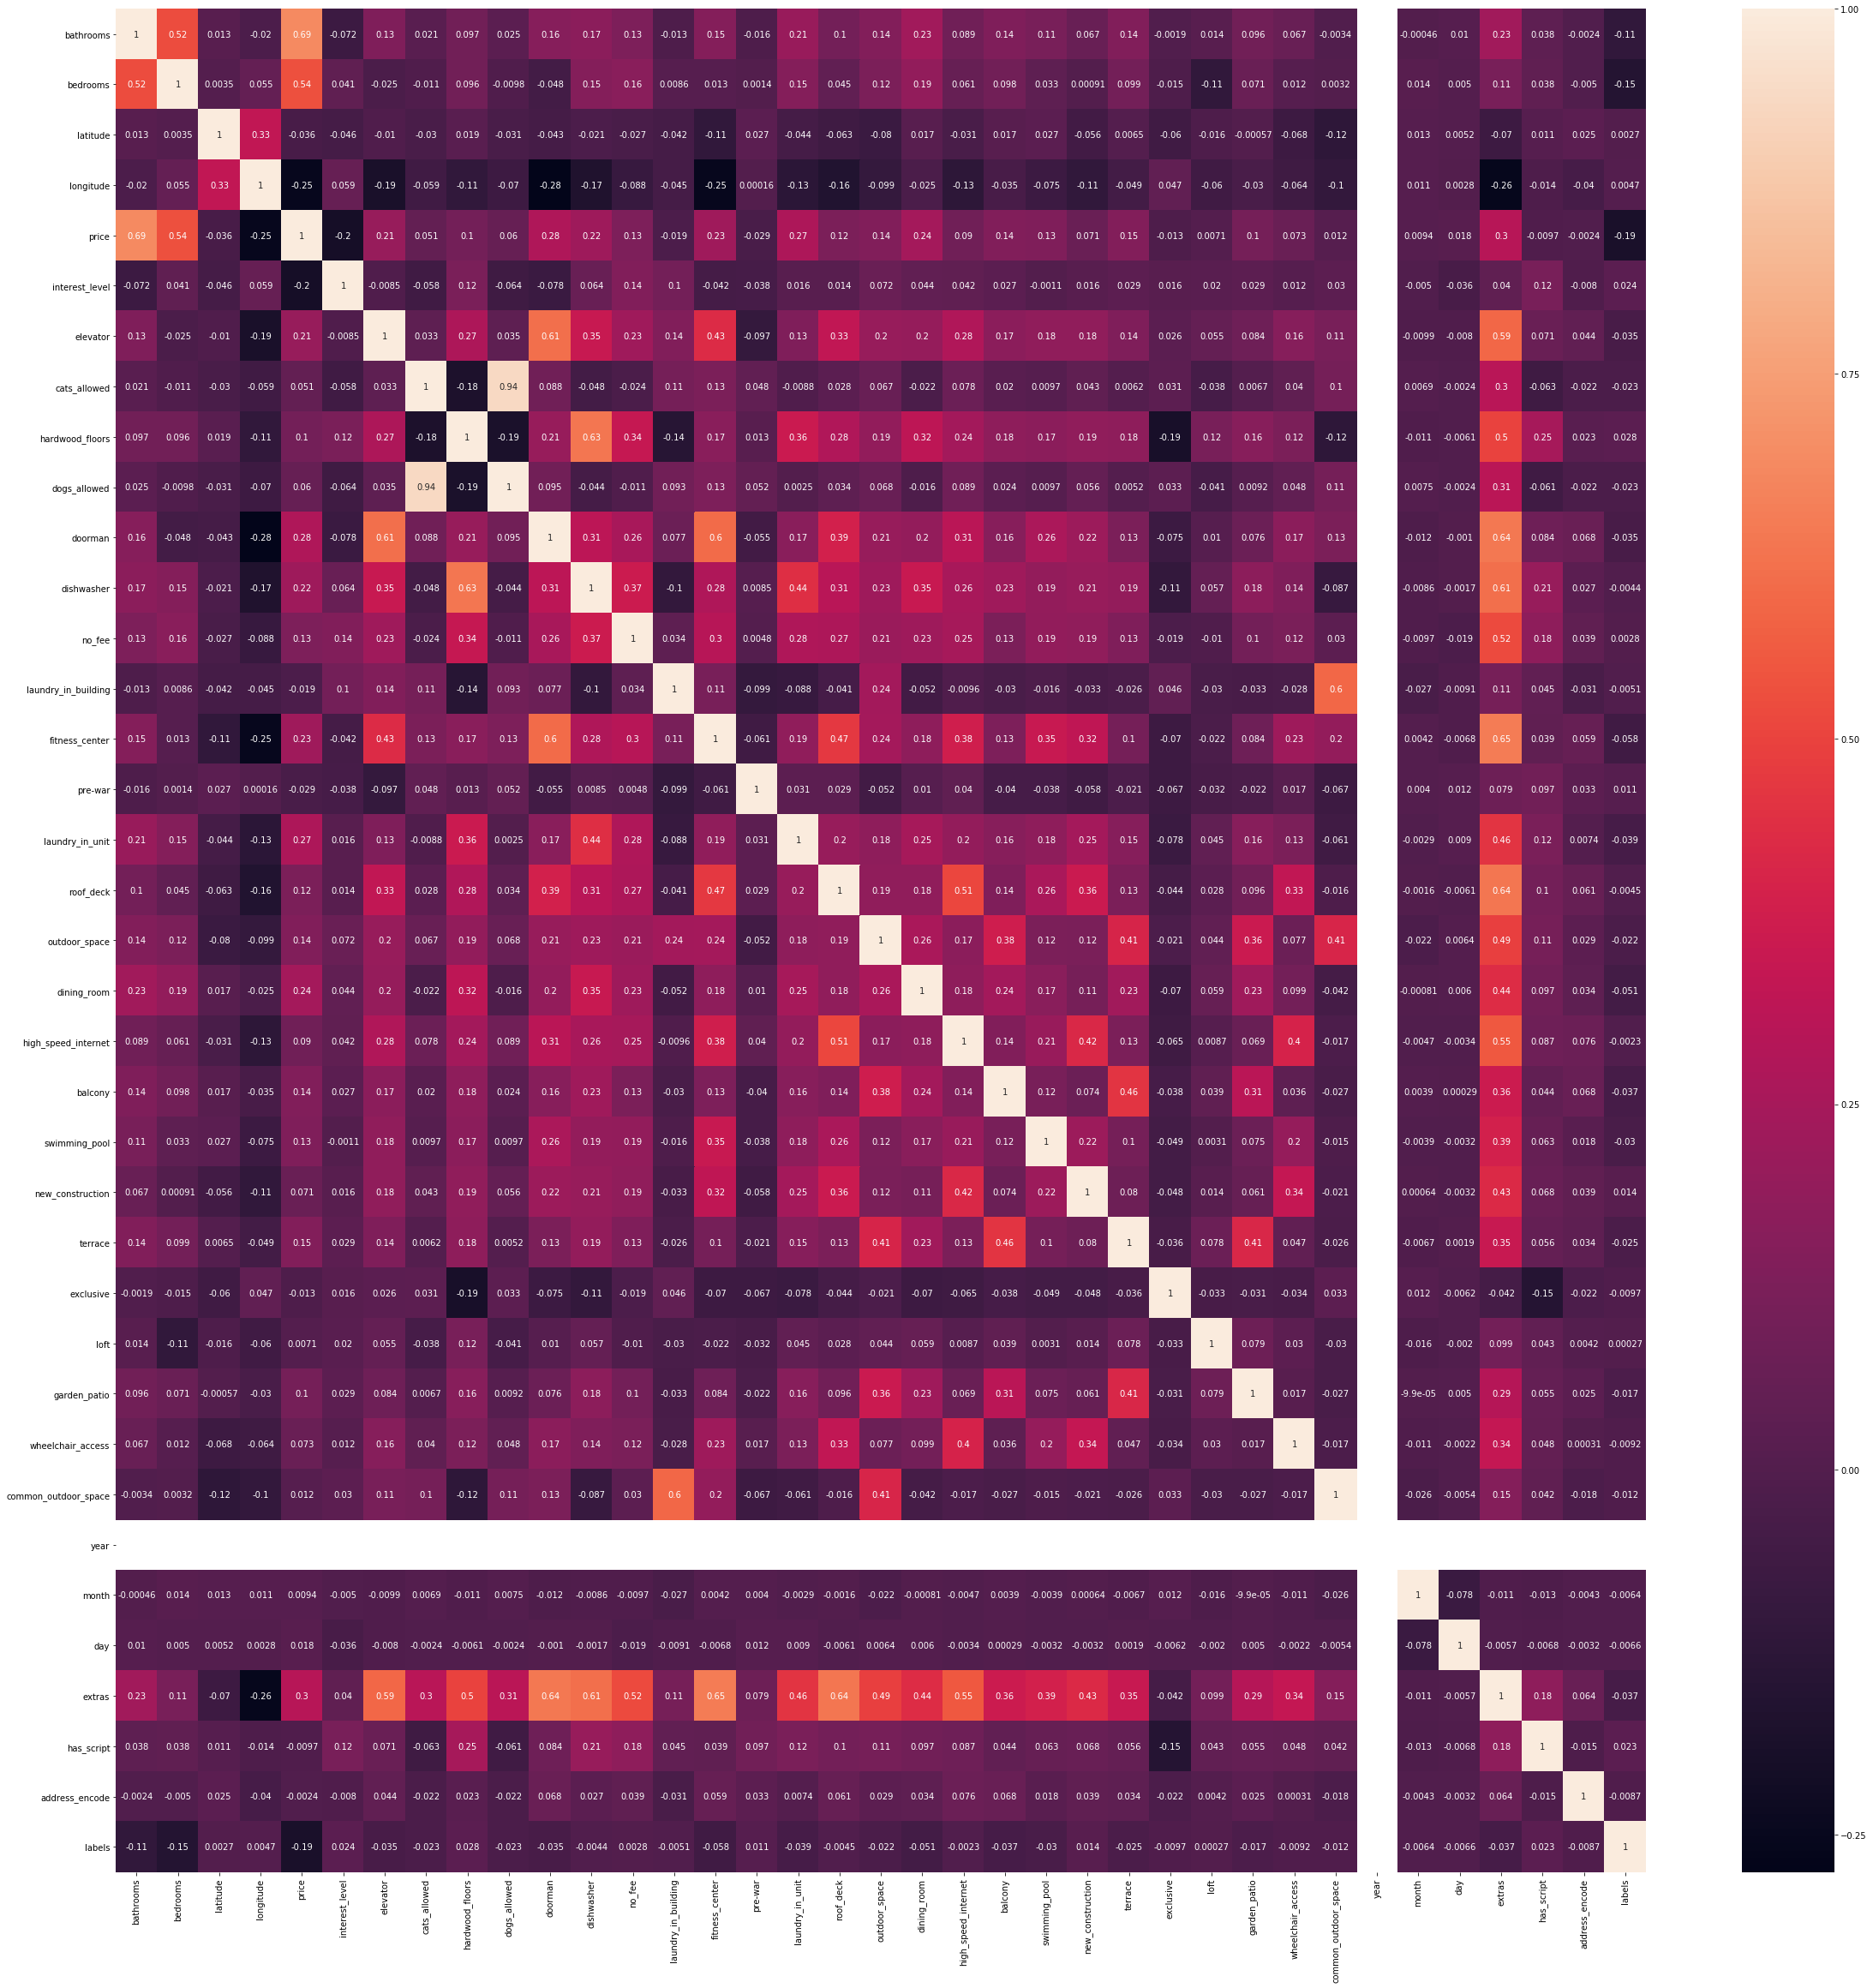

In [434]:
plt.figure(figsize=(40,40))
sns.heatmap(df.corr(), annot=True )

In [450]:
df.corr()

,bathrooms,bedrooms,latitude,longitude,price,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,...,garden_patio,wheelchair_access,common_outdoor_space,year,month,day,extras,has_script,address_encode,labels
bathrooms,1.000000,0.524077,0.013445,-0.020129,0.687297,-0.072240,0.132889,0.021484,0.096929,0.024547,...,0.096285,0.066941,-0.003401,NaN,-0.000462,0.010459,0.234347,0.037917,-0.002433,0.120947
bedrooms,0.524077,1.000000,0.003450,0.055141,0.535494,0.040729,-0.024830,-0.011181,0.096410,-0.009758,...,0.070759,0.012304,0.003232,NaN,0.014341,0.005030,0.114235,0.038433,-0.005038,0.090814
latitude,0.013445,0.003450,1.000000,0.328711,-0.036214,-0.046135,-0.010421,-0.029710,0.018739,-0.030862,...,-0.000569,-0.068300,-0.117158,NaN,0.012783,0.005179,-0.070243,0.010967,0.024648,0.003833
longitude,-0.020129,0.055141,0.328711,1.000000,-0.251018,0.059166,-0.189887,-0.058539,-0.108550,-0.070387,...,-0.029858,-0.063638,-0.102952,NaN,0.010807,0.002823,-0.256756,-0.013957,-0.040375,0.023402
price,0.687297,0.535494,-0.036214,-0.251018,1.000000,-0.203585,0.207180,0.051465,0.101515,0.060412,...,0.103675,0.072519,0.011519,NaN,0.009450,0.018236,0.299448,-0.009716,-0.002354,0.148059
interest_level,-0.072240,0.040729,-0.046135,0.059166,-0.203585,1.000000,-0.008528,-0.057764,0.119003,-0.064202,...,0.029313,0.011678,0.029866,NaN,-0.005026,-0.036059,0.039877,0.116679,-0.007965,-0.009824
elevator,0.132889,-0.024830,-0.010421,-0.189887,0.207180,-0.008528,1.000000,0.033367,0.270846,0.034851,...,0.084059,0.155397,0.114884,NaN,-0.009866,-0.007988,0.594774,0.070583,0.044037,-0.005008
cats_allowed,0.021484,-0.011181,-0.029710,-0.058539,0.051465,-0.057764,0.033367,1.000000,-0.177611,0.937246,...,0.006694,0.039659,0.104498,NaN,0.006912,-0.002445,0.302405,-0.063146,-0.022328,0.010406
hardwood_floors,0.096929,0.096410,0.018739,-0.108550,0.101515,0.119003,0.270846,-0.177611,1.000000,-0.185642,...,0.161754,0.124831,-0.120485,NaN,-0.010945,-0.006110,0.500804,0.250786,0.023188,-0.031089
dogs_allowed,0.024547,-0.009758,-0.030862,-0.070387,0.060412,-0.064202,0.034851,0.937246,-0.185642,1.000000,...,0.009233,0.048125,0.106074,NaN,0.007453,-0.002356,0.310352,-0.060524,-0.022021,0.006477


In [435]:
train = df[df['month'] < 6]
test = df[df['month'] == 6]

print(train.shape, test.shape)

(31844, 37) (16974, 37)


In [436]:
list(df.describe().columns)

['bathrooms',
 'bedrooms',
 'latitude',
 'longitude',
 'price',
 'interest_level',
 'elevator',
 'cats_allowed',
 'hardwood_floors',
 'dogs_allowed',
 'doorman',
 'dishwasher',
 'no_fee',
 'laundry_in_building',
 'fitness_center',
 'pre-war',
 'laundry_in_unit',
 'roof_deck',
 'outdoor_space',
 'dining_room',
 'high_speed_internet',
 'balcony',
 'swimming_pool',
 'new_construction',
 'terrace',
 'exclusive',
 'loft',
 'garden_patio',
 'wheelchair_access',
 'common_outdoor_space',
 'year',
 'month',
 'day',
 'extras',
 'has_script',
 'address_encode',
 'labels']

In [437]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV

model = LinearRegression()

features = ['bathrooms',
        'interest_level',
 'bedrooms',
 'latitude',
 'longitude',
 'elevator',
 'cats_allowed',
 'hardwood_floors',
 'dogs_allowed',
 'doorman',
 'dishwasher',
 'no_fee',
 'laundry_in_building',
 'fitness_center',
 'pre-war',
 'laundry_in_unit',
 'roof_deck',
 'outdoor_space',
 'dining_room',
 'high_speed_internet',
 'balcony',
 'swimming_pool',
 'new_construction',
 'terrace',
 'exclusive',
 'loft',
 'garden_patio',
 'wheelchair_access',
 'common_outdoor_space',
 'year',
 'month',
 'day',
 'labels',
 'extras',
 'has_script',
 'address_encode'
           ]

y_train = train["price"]
X_train = train[features]


y_test = test["price"]
X_test = test[features]


model.fit(X_train, y_train)
pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R^2: {r2_score(y_test, pred)}")

MAE: 668.3494140868795
MSE: 1078899.6107104982
RMSE: 1038.700924573815
R^2: 0.6528549769144357


In [449]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=27)

X_train_selected = selector.fit_transform(X_train, y_train)

/Users/mph/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/mph/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/mph/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/mph/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/mph/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [439]:
X_train_selected.shape

(31844, 27)

In [440]:
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
print(selected_names)


Index(['bathrooms', 'interest_level', 'bedrooms', 'latitude', 'longitude',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'fitness_center', 'pre-war',
       'laundry_in_unit', 'roof_deck', 'outdoor_space', 'dining_room',
       'high_speed_internet', 'balcony', 'swimming_pool', 'new_construction',
       'terrace', 'garden_patio', 'wheelchair_access', 'labels', 'extras'],
      dtype='object')


In [441]:
model = LinearRegression()

features = selected_names

y_train1 = train['price']
X_train1 = train[features]


y_test1 = test["price"]
X_test1 = test[features]


model.fit(X_train1, y_train1)
pred = model.predict(X_test1)
print(f"MAE: {mean_absolute_error(y_test1, pred)}")
print(f"MSE: {mean_squared_error(y_test1, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test1, pred))}")
print(f"R^2: {r2_score(y_test1, pred)}")

MAE: 663.0843599931004
MSE: 1084400.4663331525
RMSE: 1041.3455076645564
R^2: 0.6510850303567026


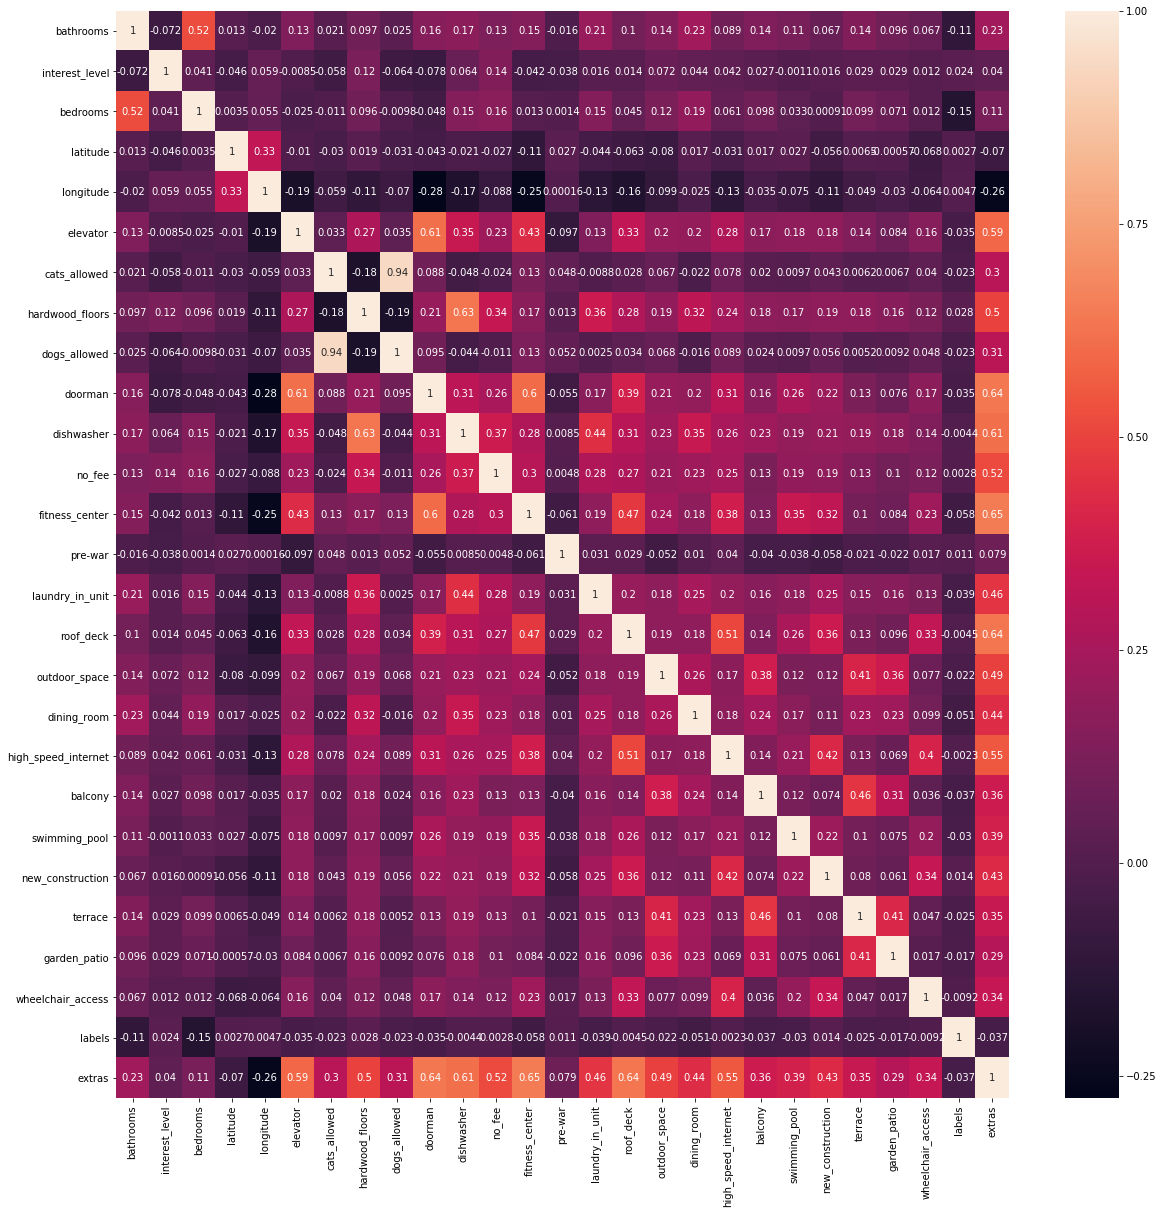

In [442]:
plt.figure(figsize=(20,20))
sns.heatmap(df[features].corr(), annot=True)

In [451]:
# ridge

model = RidgeCV(normalize=True)

features = selected_names

y_cv = df['price']
X_cv = df[features]


y_train2 = train['price']
X_train2 = train[features]


y_test2 = test["price"]
X_test2 = test[features]

model.fit(X_train2, y_train2)
pred = model.predict(X_test2)
print(f"MAE: {mean_absolute_error(y_test2, pred)}")
print(f"MSE: {mean_squared_error(y_test2, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test2, pred))}")
print(f"R^2: {r2_score(y_test2, pred)}")

MAE: 657.1509997898584
MSE: 1096761.3046257908
RMSE: 1047.2637225769786
R^2: 0.6471078266837593


(49352, 34)


MAE: 1178.016037285069
MSE: 1253275220.0050967
RMSE: 35401.62736379638
R^2: 0.002651175193925215
